# Текстовые эмбеддинги

Будем рассматривать задачу классификации текстов на 2 категории: исполняемые Киркоровым и исполняемые Монеточкой. Для работы с текстами нам понадобятся несколько дополнительных библиотек:
* nltk - большая библиотека, в которой содержится множество полезных функций для обработки текста, такие, как, например, удаление пунктуации, стемминг и лемматизацию
* snowballstemmer - стеммер для русского языка
* pymorphy2, pymystem3 - морфоанализаторы для русского языка
* gensim - библиотека, содержащая модели текстовых эмбеддингов

In [1]:
!pip install nltk snowballstemmer pymorphy2 pymystem3 gensim

     |████████████████████████████████| 51kB 574kB/s eta 0:00:01
     |████████████████████████████████| 24.2MB 2.1MB/s eta 0:00:01     |███████████████▎                | 11.6MB 821kB/s eta 0:00:16
     |████████████████████████████████| 7.1MB 1.3MB/s eta 0:00:01
     |████████████████████████████████| 71kB 278kB/s  eta 0:00:01
     |████████████████████████████████| 133kB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 5.8MB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 261kB/s  eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=3c7b6d351625c91f6cde1e76db42a49a9d13833d871ed3b4967576da0a28a4e9
  Stored in directory: /home/disco/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
  Created wheel for smart-open: filename=smart_open-1.9.0-cp37-none-any.whl size=73088 sha256=ae3c5fd4ac561e47aca4b6c7115b5a3edea7c9594792640388317708f7440b29
  Stored in directory: /home/disco/.cache/pip/

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from pandas import read_csv
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score,precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
try:
    import os
    os.chdir('F:/Neirolabs')
except ImportError:
    pass
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

## Предобработка текстов

Поскольку в русском языке много словоформ, прежде всего нужно преобразовать все тексты к единому виду.

Считаем один из файлов и посмотрим, что мы можем с ним сделать

In [2]:
out = read_csv("corp3.csv", sep=',', header=0)
out

,article,category
0,Jony Ive speaks onstage during the 2017 New Yo...,gadgets
1,Healthcare worker sets up an EEG on an ICU pat...,science
2,June was a busy month for Mac malware with the...,IT
3,A Renault Captur in more idealistic conditions...,cars
4,This story isn't really about this kind of cha...,science
...,...,...
5947,"My Late, Great Chevy Impala The first two mach...",cars
5948,Even when the instrument cluster is in navigat...,cars
5949,Chevrolet Chevrolet provided flights to North...,cars
5950,Boring Company Elon Musk's Boring Company is ...,cars


In [3]:
lem = WordNetLemmatizer()
stop_words=set(stopwords.words("english"))

def stop(value):
    filtered_sent=[]
    tokenized_sent=word_tokenize(value)
    for w in tokenized_sent:
        if w not in stop_words and w not in punctuation:
            filtered_sent.append(lem.lemmatize(w,"v"))
    return ' '.join(filtered_sent)

out['article']=out['article'].apply(stop)

In [4]:
out

,article,category
0,Jony Ive speak onstage 2017 New Yorker TechFes...,gadgets
1,Healthcare worker set EEG ICU patient Getty BS...,science
2,June busy month Mac malware active circulation...,IT
3,A Renault Captur idealistic condition Renault ...,cars
4,This story n't really kind chameleon Sorry Ren...,science
...,...,...
5947,My Late Great Chevy Impala The first two machi...,cars
5948,Even instrument cluster navigation mode traffi...,cars
5949,Chevrolet Chevrolet provide flight North Carol...,cars
5950,Boring Company Elon Musk 's Boring Company nea...,cars


In [5]:
from sklearn import preprocessing
data = pd.DataFrame(columns=['article', 'category'])
data['article']=out['article']
le = preprocessing.LabelEncoder()
le.fit(out['category'])
data['category'] = le.transform(out['category'])

## Формирование выборки сырых данных

Обернем наши предыдущие действия в функцию:

In [14]:
out.to_csv("Lemmatized_corps.csv")

In [2]:
pf = read_csv("Lemmatized_corps.csv", sep=',', header=0)

In [3]:
pf = read_csv("Lemmatized_corps_named.csv", sep=',', header=0)

Разобьем выборку на трейн и тест

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pf['article'], pf['category'], test_size=0.33, stratify=pf['category'])

## Bag-of-Words-эмбеддинг

Понятное дело, работать с чистым текстом математические методы не умеют. Настало время получить эмбеддинги!

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vect = CountVectorizer()
bow_vect.fit(pf['article'])
bow_train = bow_vect.transform(X_train)
bow_test = bow_vect.transform(X_test)

Заметьте, что обучение эмбеддинга проводится на всех данных, не только на тренировочной выборке. О том, почему так, будет вопрос на защите =)

In [5]:
bow_train.toarray()

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [6]:
bow_train.toarray().shape

(3987, 65349)

## TF-IDF-эмбеддинг

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(pf['article'])
tfidf_train = tfidf_vect.transform(X_train)
tfidf_test = tfidf_vect.transform(X_test)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)
tfidf_train = tfidf_vect.transform(X_train)
tfidf_test = tfidf_vect.transform(X_test)

In [6]:
tfidf_train.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01604396, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [7]:
tfidf_train.toarray().shape

(3987, 55451)

## Word2vec-эмбеддинг
Поскольку w2v - это не sklearn'овский классификатор, он на выходе выдаст данные немного другого вида, и это надо будет учитывать в дальнейшей работе

In [8]:
from gensim.models import Word2Vec
X_train_w2v = X_train.apply(str.split)
X_test_w2v = X_test.apply(str.split)
w2v_vect = Word2Vec(np.hstack([X_train_w2v, X_test_w2v]), size=300, min_count=10, workers=8)

In [9]:
def text2vec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(w2v_vect[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)

w2v_train = X_train_w2v.apply(text2vec)
w2v_test = X_test_w2v.apply(text2vec)

D:\download\ana\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [10]:
w2v_train = np.dstack(w2v_train)[0]
w2v_train = np.dstack(w2v_train)[0]
w2v_train.shape

(3987, 300)

In [11]:
w2v_test = np.dstack(w2v_test)[0]
w2v_test = np.dstack(w2v_test)[0]
w2v_test.shape

(1965, 300)

## Классификация текстов

Теперь у нас есть классическое признаковое описание каждого текста. Можем обучать классификаторы или придумать еще какую-то метрику.

Давайте вычислим для каждого эмбеддинга по два суммарных вектора - для текстов Филиппа и для текстов Арии. Для Bag of Words:

cars = 0
science = 1
gadgets = 2
games = 3
IT = 4

In [35]:
SVM_bow = svm.SVC(kernel='linear', gamma='auto')
SVM_bow.fit(bow_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
a = SVM_bow.predict(bow_test.toarray())
print('Precision:', precision_score(y_test.tolist(), a,average='micro'))  
print('Recall:', recall_score(y_test.tolist(), a,average='macro'))
print('F1:', f1_score(y_test.tolist(), a,average='micro'))
print('F0.5:', fbeta_score(y_test.tolist(), a, 0.5,average='micro'))
print('F2:', fbeta_score(y_test.tolist(), a, 2,average='micro'))

Precision: 0.9480916030534351
Recall: 0.9480879189739035
F1: 0.9480916030534351
F0.5: 0.9480916030534351
F2: 0.9480916030534351


In [6]:
SVM_tfidf = svm.SVC(kernel='linear', gamma='auto')
SVM_tfidf.fit(tfidf_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
a = SVM_tfidf.predict(tfidf_test.toarray())
print('Precision:', precision_score(y_test.tolist(), a,average='micro'))  
print('Recall:', recall_score(y_test.tolist(), a,average='macro'))
print('F1:', f1_score(y_test.tolist(), a,average='micro'))
print('F0.5:', fbeta_score(y_test.tolist(), a, 0.5,average='micro'))
print('F2:', fbeta_score(y_test.tolist(), a, 2,average='micro'))

Precision: 0.9567430025445293
Recall: 0.9567368933495356
F1: 0.9567430025445293
F0.5: 0.9567430025445293
F2: 0.9567430025445293


In [39]:
SVM_w2v = svm.SVC(kernel='linear', gamma='auto')
SVM_w2v.fit(w2v_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
a = SVM_w2v.predict(w2v_test)
print('Precision:', precision_score(y_test.tolist(), a,average='micro'))  
print('Recall:', recall_score(y_test.tolist(), a,average='macro'))
print('F1:', f1_score(y_test.tolist(), a,average='micro'))
print('F0.5:', fbeta_score(y_test.tolist(), a, 0.5,average='micro'))
print('F2:', fbeta_score(y_test.tolist(), a, 2,average='micro'))

Precision: 0.9384223918575063
Recall: 0.9384185825154396
F1: 0.9384223918575063
F0.5: 0.9384223918575063
F2: 0.9384223918575063


# Композиции алгоритмов

In [14]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=13,max_depth=50)
clf.fit(bow_train.toarray(), y_train.tolist())

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=50, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=13, verbose=0,
                     warm_start=False)

In [15]:
a1 = clf.predict(bow_test.toarray())
a = a1

In [16]:
print('Precision:', precision_score(y_test.tolist(), a,average='micro'))  
print('Recall:', recall_score(y_test.tolist(), a,average='macro'))
print('F1:', f1_score(y_test.tolist(), a,average='micro'))
print('F0.5:', fbeta_score(y_test.tolist(), a, 0.5,average='micro'))
print('F2:', fbeta_score(y_test.tolist(), a, 2,average='micro'))

Precision: 0.9353689567430026
Recall: 0.9353456474004711
F1: 0.9353689567430026
F0.5: 0.9353689567430027
F2: 0.9353689567430027


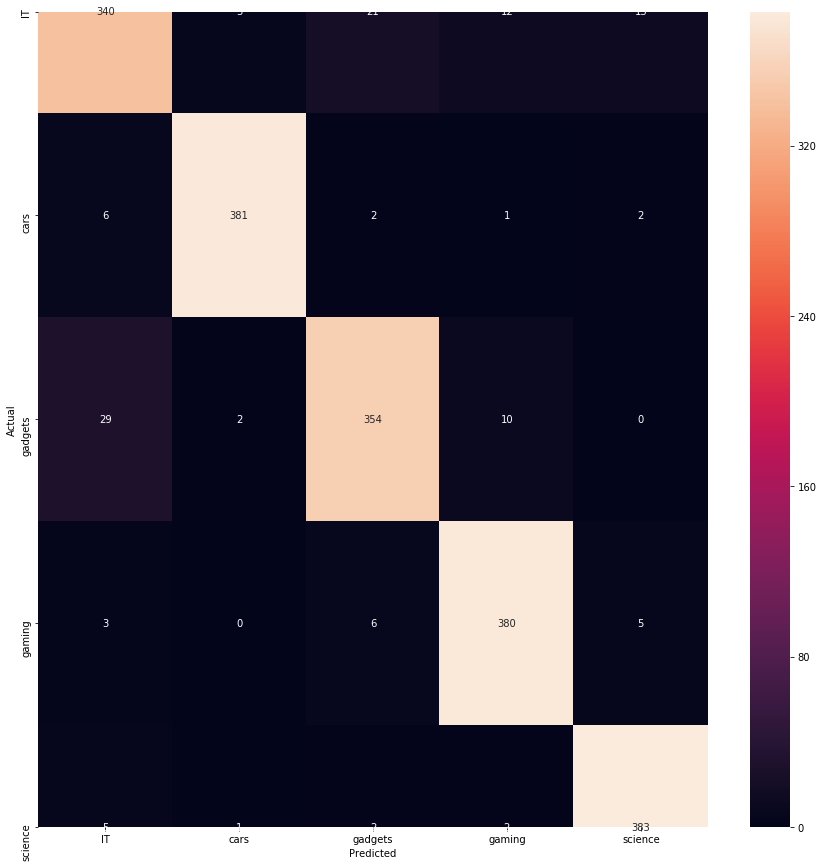

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

conf_mat = confusion_matrix(y_test, a1)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
clf = RandomForestClassifier(max_depth=50, random_state=0)
clf.fit(tfidf_train.toarray(), y_train.tolist())

/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [20]:
b = clf.predict(tfidf_test.toarray())
a = b

In [21]:
print('Precision:', precision_score(y_test.tolist(), a,average='micro'))  
print('Recall:', recall_score(y_test.tolist(), a,average='macro'))
print('F1:', f1_score(y_test.tolist(), a,average='micro'))
print('F0.5:', fbeta_score(y_test.tolist(), a, 0.5,average='micro'))
print('F2:', fbeta_score(y_test.tolist(), a, 2,average='micro'))

Precision: 0.8585241730279898
Recall: 0.8585592717562698
F1: 0.8585241730279898
F0.5: 0.8585241730279898
F2: 0.8585241730279898


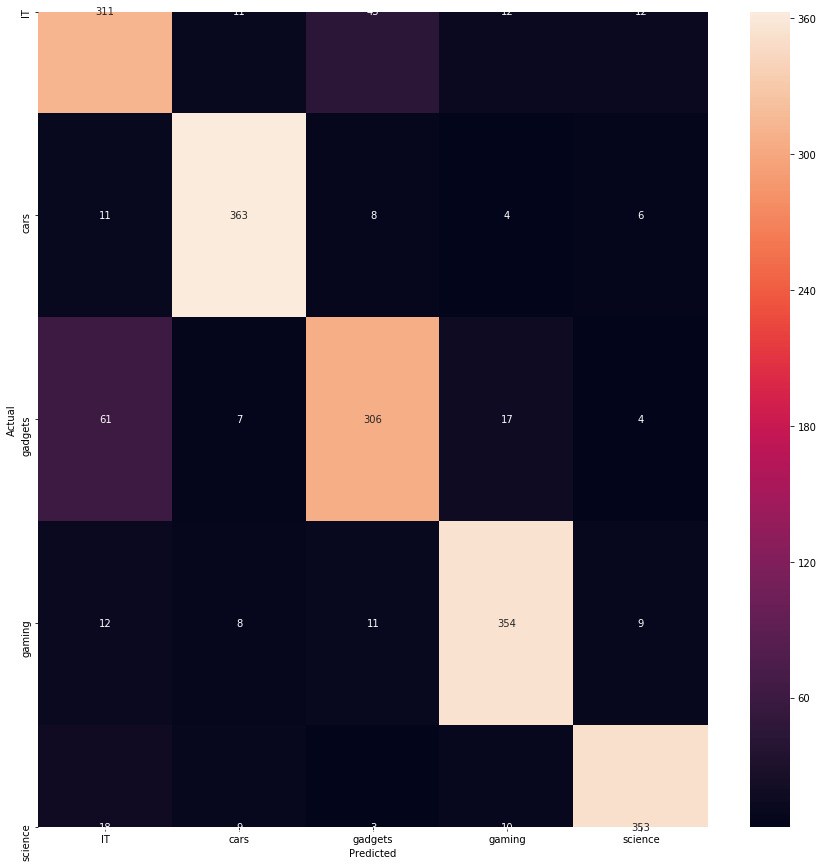

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

conf_mat = confusion_matrix(y_test, b)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [24]:
clf = RandomForestClassifier(max_depth=50, random_state=8)
clf.fit(np.vstack(w2v_train.values), y_train.tolist())

/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [26]:
c = clf.predict(np.vstack(w2v_test.values))
a = c

In [27]:
print('Accuracy:', accuracy_score(y_test.tolist(), a))
print('Precision:', precision_score(y_test.tolist(), a,average='micro'))  
print('Recall:', recall_score(y_test.tolist(), a,average='macro'))
print('F1:', f1_score(y_test.tolist(), a,average='micro'))
print('F0.5:', fbeta_score(y_test.tolist(), a, 0.5,average='micro'))
print('F2:', fbeta_score(y_test.tolist(), a, 2,average='micro'))

Accuracy: 0.9333333333333333
Precision: 0.9333333333333333
Recall: 0.9333476536750128
F1: 0.9333333333333333
F0.5: 0.9333333333333333
F2: 0.9333333333333333


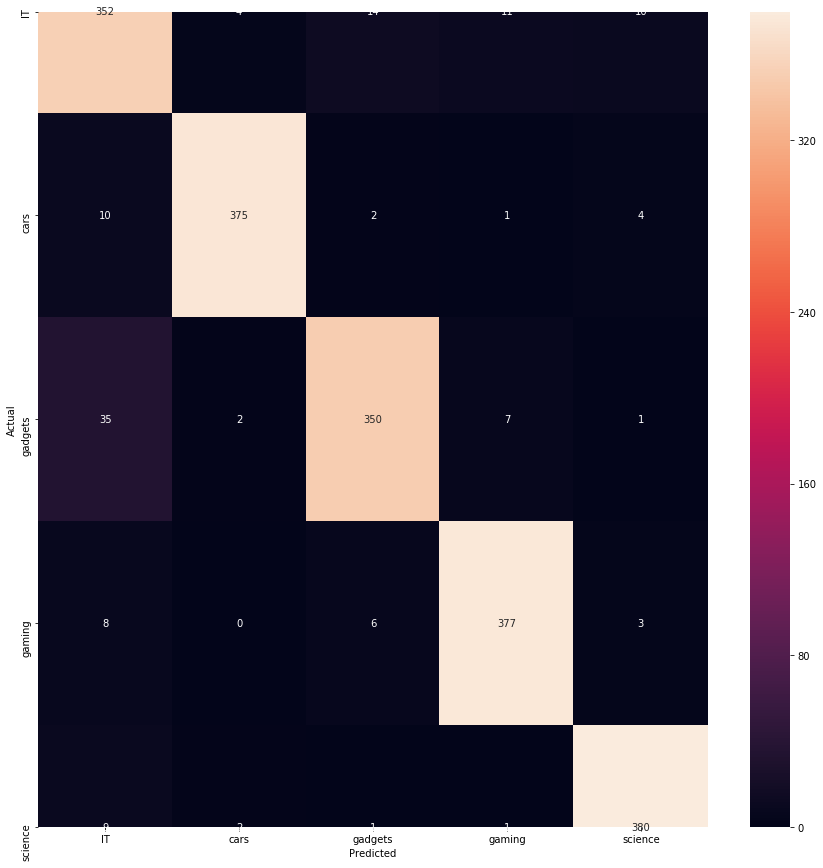

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

conf_mat = confusion_matrix(y_test, c)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()